# Applying Feed Forward in PyTorch to Real Data
Last time, we looked at simple feed forward with some randomly generated numbers. This time we will use real-world image data. The goal is to eventually train a network that takes a 28x28 pixel grayscale image of a hand written number between 0 and 9 and accurately classfies it. 

Because there are 10 possible digits that an input can be classified as, our network will need to have 10 outputs. Each of the 10 outputs will represent a probability of the input being classified as one of the 10 numbers. For example, output 1 will represent the probability that th input is a 1. Output 2 will be the probability that the input is a 2. 

In [14]:
from torchvision import datasets, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Transforms
We will be using grayscale image data, which is nothing but numeric values ranging from 0 to 255 for black to white. In order for a neural network to train well, input data needs to be normalized so that it all falls within a fairly compact range. Also, all PyTorch implementations require that incoming data be in tensor format. 

Below is a simple transform that takes in pixel data from an image, converts it to a `torch.tensor` and then standardizes it to a range between -1 and 1. 

In [15]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Datasets and Dataloaders
PyTorch comes pre-packaged with some common data sets, which allows you to learn to use PyTorch rather than fumbling together your own dataset. 

Additionally, PyTorch has an object called a `DataLoader` which is nothing more than an efficient way to shuffle chunk your data into smaller pieces to feed to a neural network. 

If you do need to create a custom dataset, but want to use PyTorch's awesome features, here is a tutorial on how to create and extend their `Dataset` and `DataLoader` code: 

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

For now, here is how you load the standard issue MNIST dataset into a `DataLoader`:

In [16]:
# download and load MNIST training data:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

`batch_size` is nothing more than the number of images to feed into your network at a time. Your choice of this number will be dictated by the amount of memory you want to use at a time. 

## Displaying the Data
Alright, now we have our data and we'd like to take a look at it. We will oad our first 'batch' of images, which should be of size 64. 

Next, we will display the first image in the batch.

In [17]:
# Get first batch of images from the trainloader
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


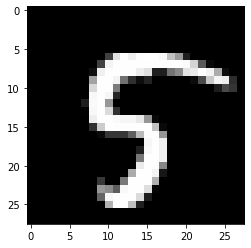

In [18]:
# display first image in first batch:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

## Initializing Network Weights and Biases
Now, we initialize our 'Network' in the exact manner that was covered in the last section.

In [19]:
# Define network architecture:
n_in = 784
n_hidden = 256
n_out = 10

# randomly initialize weight matrices:
W1 = torch.randn((n_in, n_hidden))
W2 = torch.randn((n_hidden, n_out))
b1 = torch.randn((1, n_hidden))
b2 = torch.randn((1, n_out))

# define activation function:
def activation(x):
    return 1/(1 + torch.exp(-x))

## Feed Forward With a New Twist
In the previous section, we used the sigmoid activation function on the output layer. This time, as mentioned, our network will have 10 outputs, one for the probability of each possible digit. For this reason, we will use a __Softmax__ activation function.

$$\text{out}_i = \frac{e^{z_i}}{\sum_{j}e^{z_j}}$$

The Softmax function does two things for us:

1. It squishes the outputs of the final layer to each be betweein 0 and 1. 
2. It ensures that the sum of all probabilites adds to equal 1. 

In [20]:
# Perform feedforward:
a1 = activation(torch.mm(images.reshape(64, -1), W1) + b1)
out = torch.mm(a1, W2) + b2

In [21]:
# 64 batches, each with 10 output probabilites.
out.shape

torch.Size([64, 10])

In [22]:
# Define Softmax function:
def softmax(z):
    ez = torch.exp(z)
    return ez/ez.sum(dim=1).view(-1, 1)

__Note:__ Because the output of the network has dimensions (64, 10) representing 64 batches of 10 outputs each, it is important that we apply softmax to the right dimension. Each column of data represents one of 10 outputs, and so it is to these columns that we want to apply the softmax function. Hence, you see `dim=1` in the function above. 

In [23]:
# Probabilites should sum to 1 with softmax:
probabilities = softmax(out)
probabilities.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

## Visualizing Our Results
Now we have run the first 64 images through our network. Lets take a look at our first image and our networks prediction of what that image represents. Since the network is 'untrained', we should get pretty bad predictions.

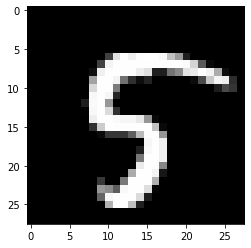

In [24]:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')

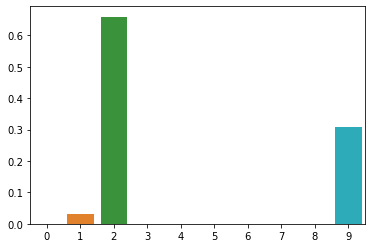

In [25]:
# Visualize the probability distribution of the given image
sns.barplot(x=np.arange(10), y=probabilities[0])

In [26]:
# Sure enough, the network thinks this one is a three (and it's 100 percent sure of itself!)
probabilities[0]

tensor([6.3293e-07, 3.2592e-02, 6.5972e-01, 5.4755e-04, 6.4431e-08, 1.2207e-08,
        2.5017e-07, 1.8994e-18, 3.8105e-10, 3.0714e-01])

As expected, the network did not guess correctly. It believes the highest probability is that the input image is a 2 (66%). 